In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import boxcox
from scipy.stats import f_oneway
from sklearn.preprocessing import PowerTransformer

In [6]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
# Load the training and testing datasets from the previous step 
data_train = pd.read_csv('data_train (1).csv')
data_test = pd.read_csv('data_test.csv')

In [15]:
# Summary Statistics for Numerical Features
data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
odometer_value,50000.0,249219.881980,136361.343789,0.0,158000.0,250000.0,325000.0,1000000.0
year_produced,50000.0,2002.945620,8.067141,1942.0,1998.0,2003.0,2009.0,2019.0
engine_capacity,49985.0,2.056894,0.675106,0.2,1.6,2.0,2.3,8.0
number_of_photos,50000.0,9.662420,6.145263,1.0,5.0,8.0,12.0,86.0
number_of_maintenance,50000.0,16.256940,41.537349,1.0,2.0,5.0,16.0,1273.0
duration_listed,50000.0,80.739440,113.606476,0.0,23.0,59.0,91.0,2232.0
price_usd,50000.0,6654.891274,6467.096697,1.0,2100.0,4800.0,8990.0,50000.0


In [17]:
# Filter and analyze cars with price less than $300
low_priced_cars = data_train[data_train['price_usd'] < 300]

# Display basic statistics and the first few rows of low priced cars
summary_low_priced = low_priced_cars.describe()
low_priced_cars_head = low_priced_cars.head()

summary_low_priced

,odometer_value,year_produced,engine_capacity,number_of_photos,number_of_maintenance,duration_listed,price_usd
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,271110.962319,1990.376812,1.600580,5.484058,17.617391,72.214493,213.491130
std,219203.698921,5.534515,0.312529,3.233258,49.083327,124.854382,64.825389
min,1.000000,1963.000000,0.800000,1.000000,1.000000,0.000000,1.000000
25%,100000.000000,1987.000000,1.400000,3.000000,1.000000,13.000000,190.110000
50%,245000.000000,1991.000000,1.600000,5.000000,2.000000,32.000000,226.890000
75%,350000.000000,1994.000000,1.800000,7.000000,10.000000,72.000000,250.000000
max,1000000.000000,2008.000000,2.900000,21.000000,393.000000,749.000000,299.630000


In [19]:
# Remove rows where the price is less than $200 USD
data_train = data_train[data_train['price_usd'] >= 200]

In [20]:
# Summary Statistics for Categorical Features
categorical_features = data_train.select_dtypes(include=['object']).columns
data_train[categorical_features].describe().transpose()

,count,unique,top,freq
manufacturer_name,49912,55,Volkswagen,5475
transmission,49912,2,manual,33190
color,49912,12,black,9972
engine_fuel,49912,6,gasoline,31182
engine_type,49912,3,gasoline,33248
body_type,49912,12,sedan,16861
ownership,49912,3,owned,48905
type_of_drive,49912,3,front,35945


In [22]:
# Identifying numerical non-binary features
numerical_features = data_train.select_dtypes(include=['int64', 'float64']).columns
# Identify all binary features
binary_features = [col for col in data_train.columns if data_train[col].nunique() == 2]

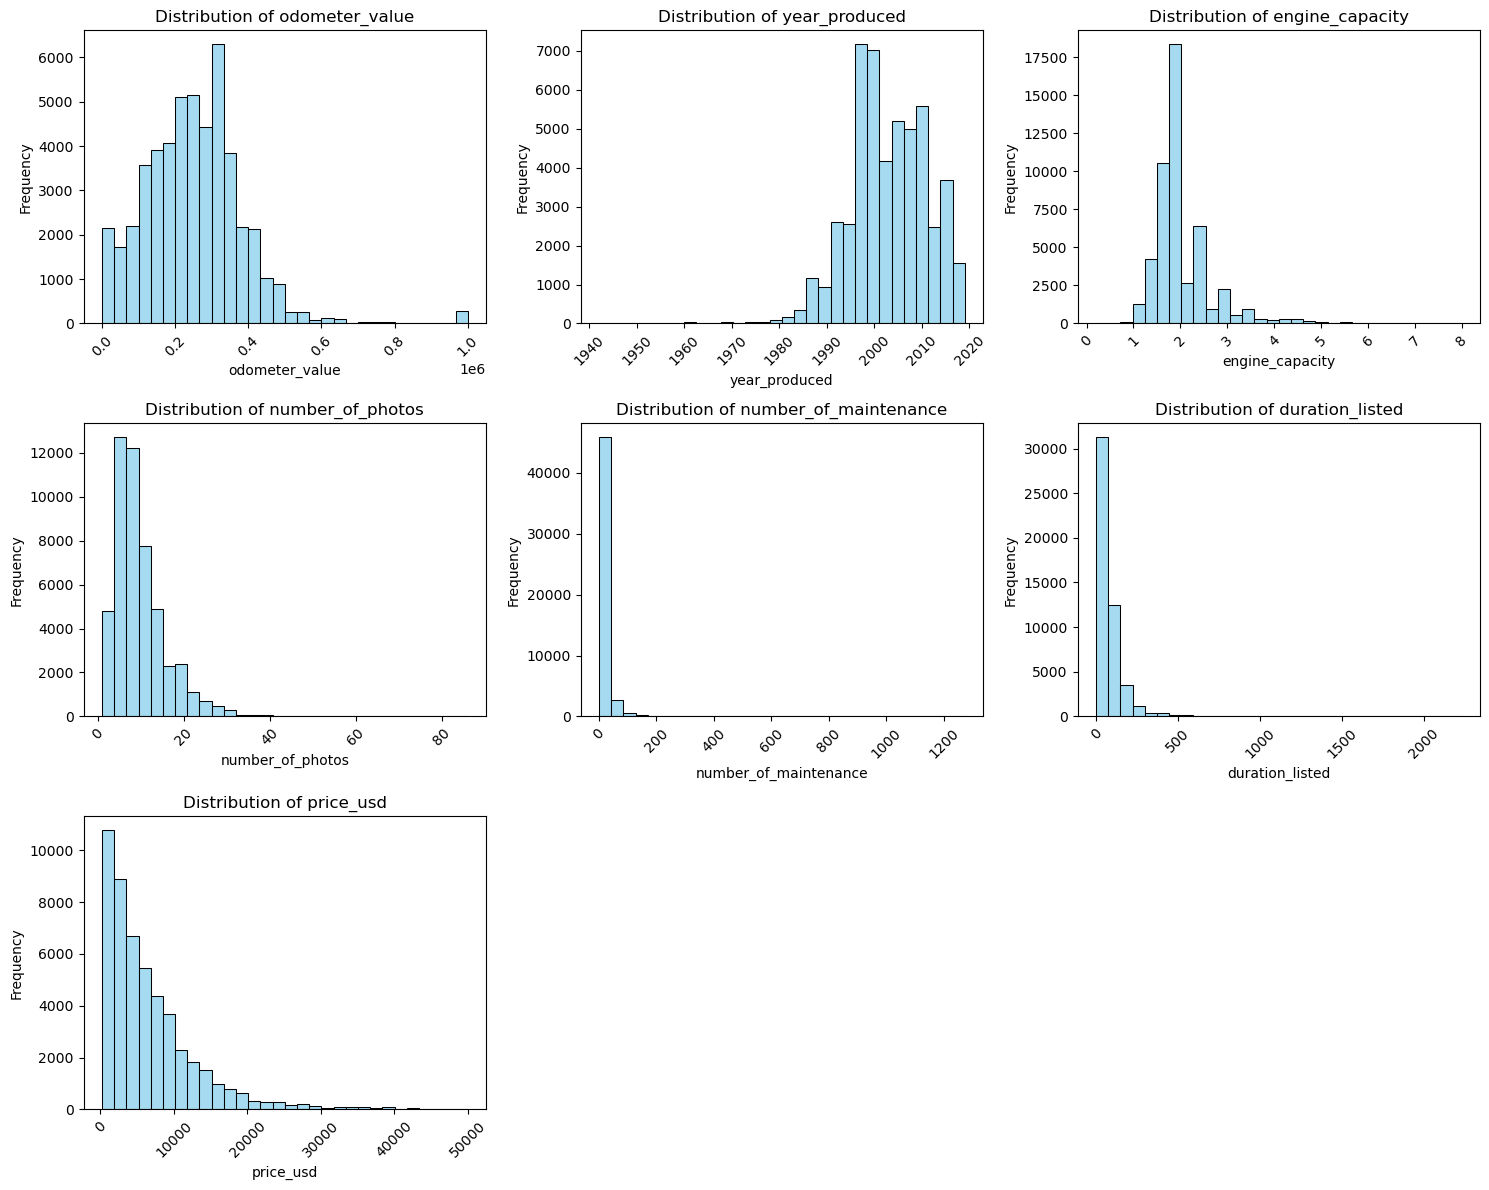

In [24]:
numerical_non_binary_features = [feature for feature in numerical_features if feature not in binary_features]

# Defining the number of rows and columns for the subplots
n_numerical_non_binary_features = len(numerical_non_binary_features)
n_cols_non_binary = 3
n_rows_non_binary = -(-n_numerical_non_binary_features // n_cols_non_binary)  # Ceiling division

# Create subplots with the adjusted number of rows
fig, axes = plt.subplots(n_rows_non_binary, n_cols_non_binary, figsize=(15, n_rows_non_binary * 4))

# If there's more than one subplot, flatten axes for easy iteration
if n_numerical_non_binary_features > 1:
    axes = axes.flatten()

# Plot distribution of each numerical non-binary feature
for i, feature in enumerate(numerical_non_binary_features):
    sns.histplot(data_train[feature], kde=False, ax=axes[i], color='skyblue', bins=30)
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)
    axes[i].set_xlabel(f'{feature}')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', labelrotation=45)

# Removing any empty subplots
for j in range(i+1, n_rows_non_binary * n_cols_non_binary):
    fig.delaxes(axes[j])

# Adjust the spacing between plots
plt.tight_layout()
plt.show()

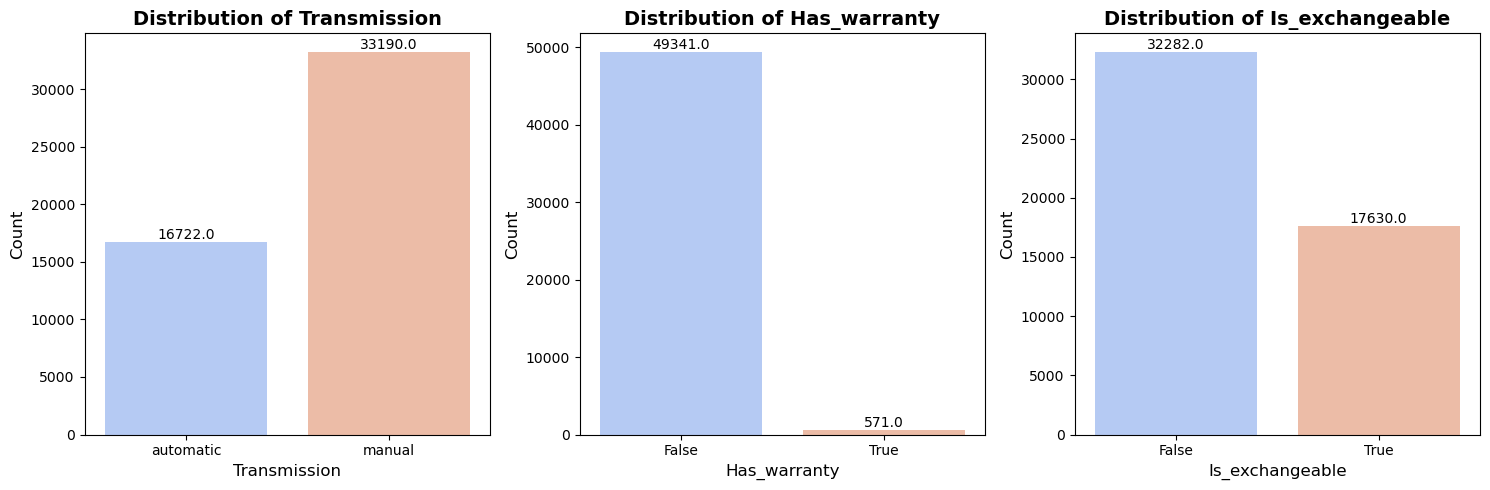

In [26]:
# Number of binary features
n_binary_features = len(binary_features)

# Calculate number of rows and columns for the subplot
n_rows_binary = -(-n_binary_features // 3)  # Ceiling division to determine rows
n_cols_binary = 3

# Create subplots
fig, axes = plt.subplots(n_rows_binary, n_cols_binary, figsize=(15, n_rows_binary * 5))
axes = axes.flatten()

# Plot distribution of each binary feature
for i, feature in enumerate(binary_features):
    sns.countplot(data=data_train, x=feature, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Distribution of {feature.capitalize()}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f'{feature.capitalize()}', fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', labelrotation=0)
    
    # Annotate bar plots
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                         textcoords='offset points')

# Adjust the spacing between plots and remove empty subplots
plt.tight_layout()
for j in range(n_binary_features, n_rows_binary * n_cols_binary):
    fig.delaxes(axes[j])
plt.show()

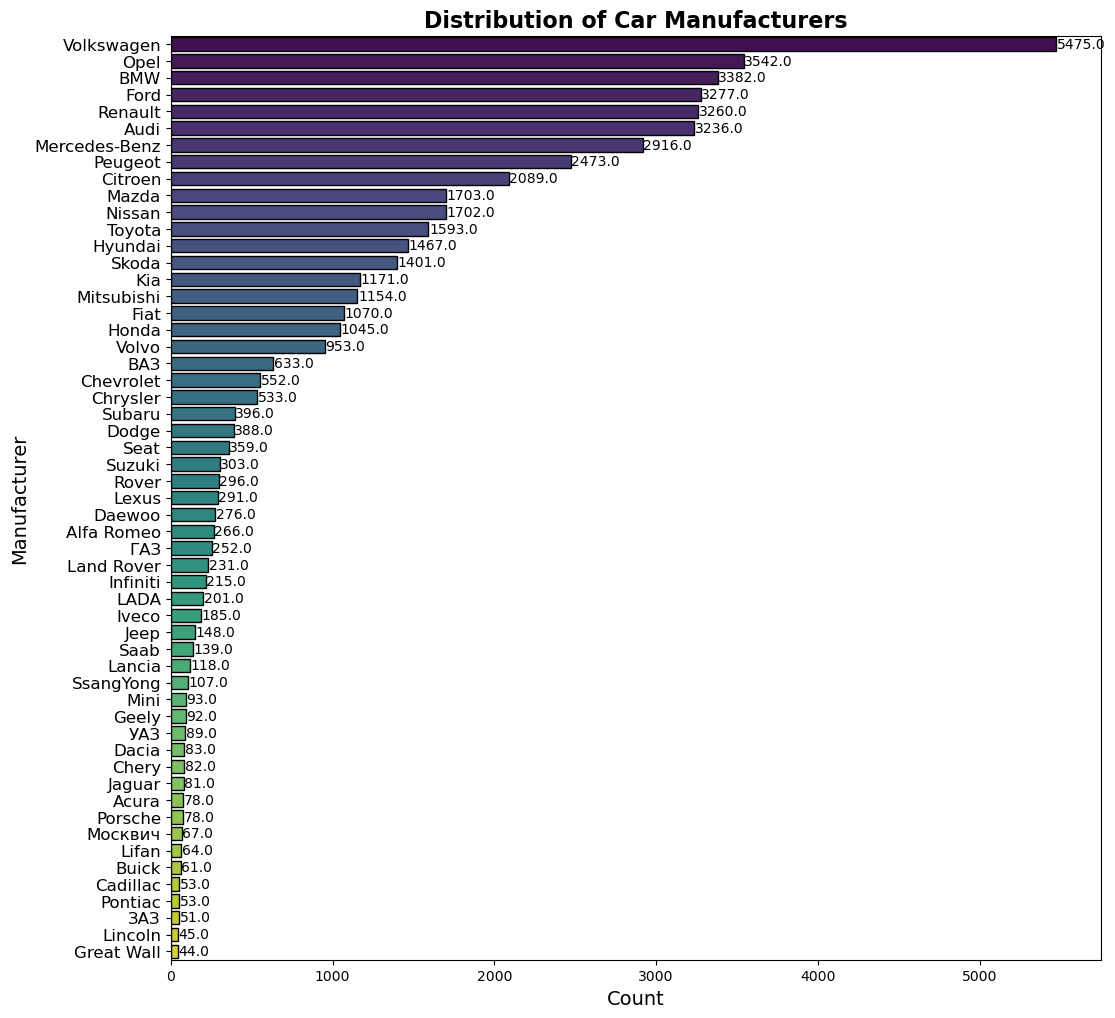

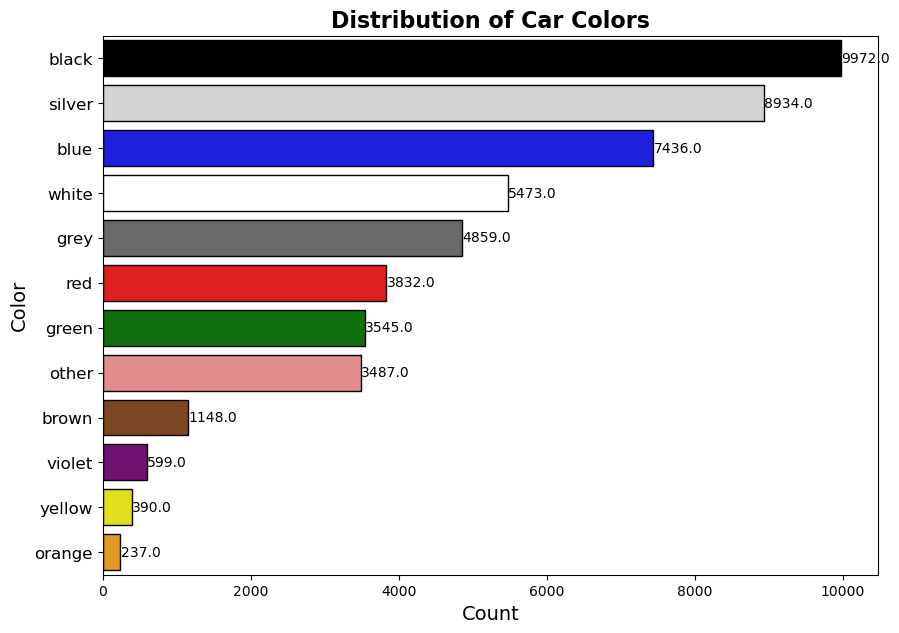

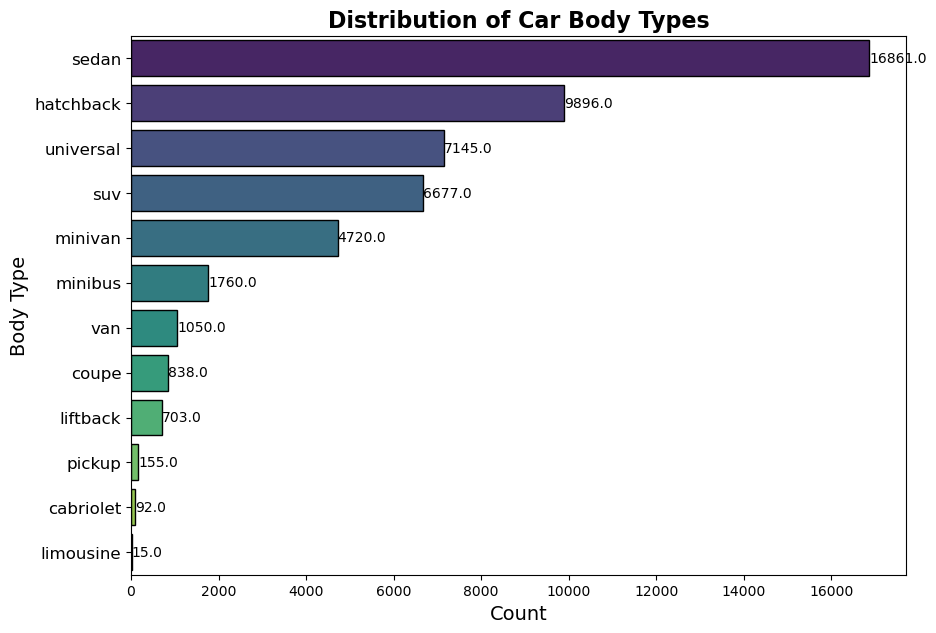

In [28]:
# Color mapping to match car colors
color_mapping = {
    'black': 'black', 
    'white': 'white', 
    'silver': 'lightgrey', 
    'blue': 'blue', 
    'grey': 'dimgrey', 
    'red': 'red', 
    'green': 'green', 
    'other': 'lightcoral', 
    'brown': 'saddlebrown', 
    'violet': 'purple', 
    'orange': 'orange', 
    'yellow': 'yellow'
}

# Manufacturer Name Distribution
fig, ax = plt.subplots(figsize=(12, 12))
order_manufacturer = data_train['manufacturer_name'].value_counts().index
sns.countplot(data=data_train, y='manufacturer_name', order=order_manufacturer, palette='viridis', ax=ax, edgecolor='black')
ax.set_title('Distribution of Car Manufacturers', fontsize=16, fontweight='bold')
ax.set_ylabel('Manufacturer', fontsize=14)
ax.set_xlabel('Count', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3, p.get_y() + p.get_height() / 2, f'{width}', va='center', fontsize=10)

# Car Color Distribution
fig, ax = plt.subplots(figsize=(10, 7))
order_color = data_train['color'].value_counts().index
sns.countplot(data=data_train, y='color', order=order_color, palette=color_mapping, ax=ax, edgecolor='black')
ax.set_title('Distribution of Car Colors', fontsize=16, fontweight='bold')
ax.set_ylabel('Color', fontsize=14)
ax.set_xlabel('Count', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3, p.get_y() + p.get_height() / 2, f'{width}', va='center', fontsize=10)

# Car Body Type Distribution
fig, ax = plt.subplots(figsize=(10, 7))
order_body_type = data_train['body_type'].value_counts().index
sns.countplot(data=data_train, y='body_type', order=order_body_type, palette='viridis', ax=ax, edgecolor='black')
ax.set_title('Distribution of Car Body Types', fontsize=16, fontweight='bold')
ax.set_ylabel('Body Type', fontsize=14)
ax.set_xlabel('Count', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3, p.get_y() + p.get_height() / 2, f'{width}', va='center', fontsize=10)
    
plt.show()

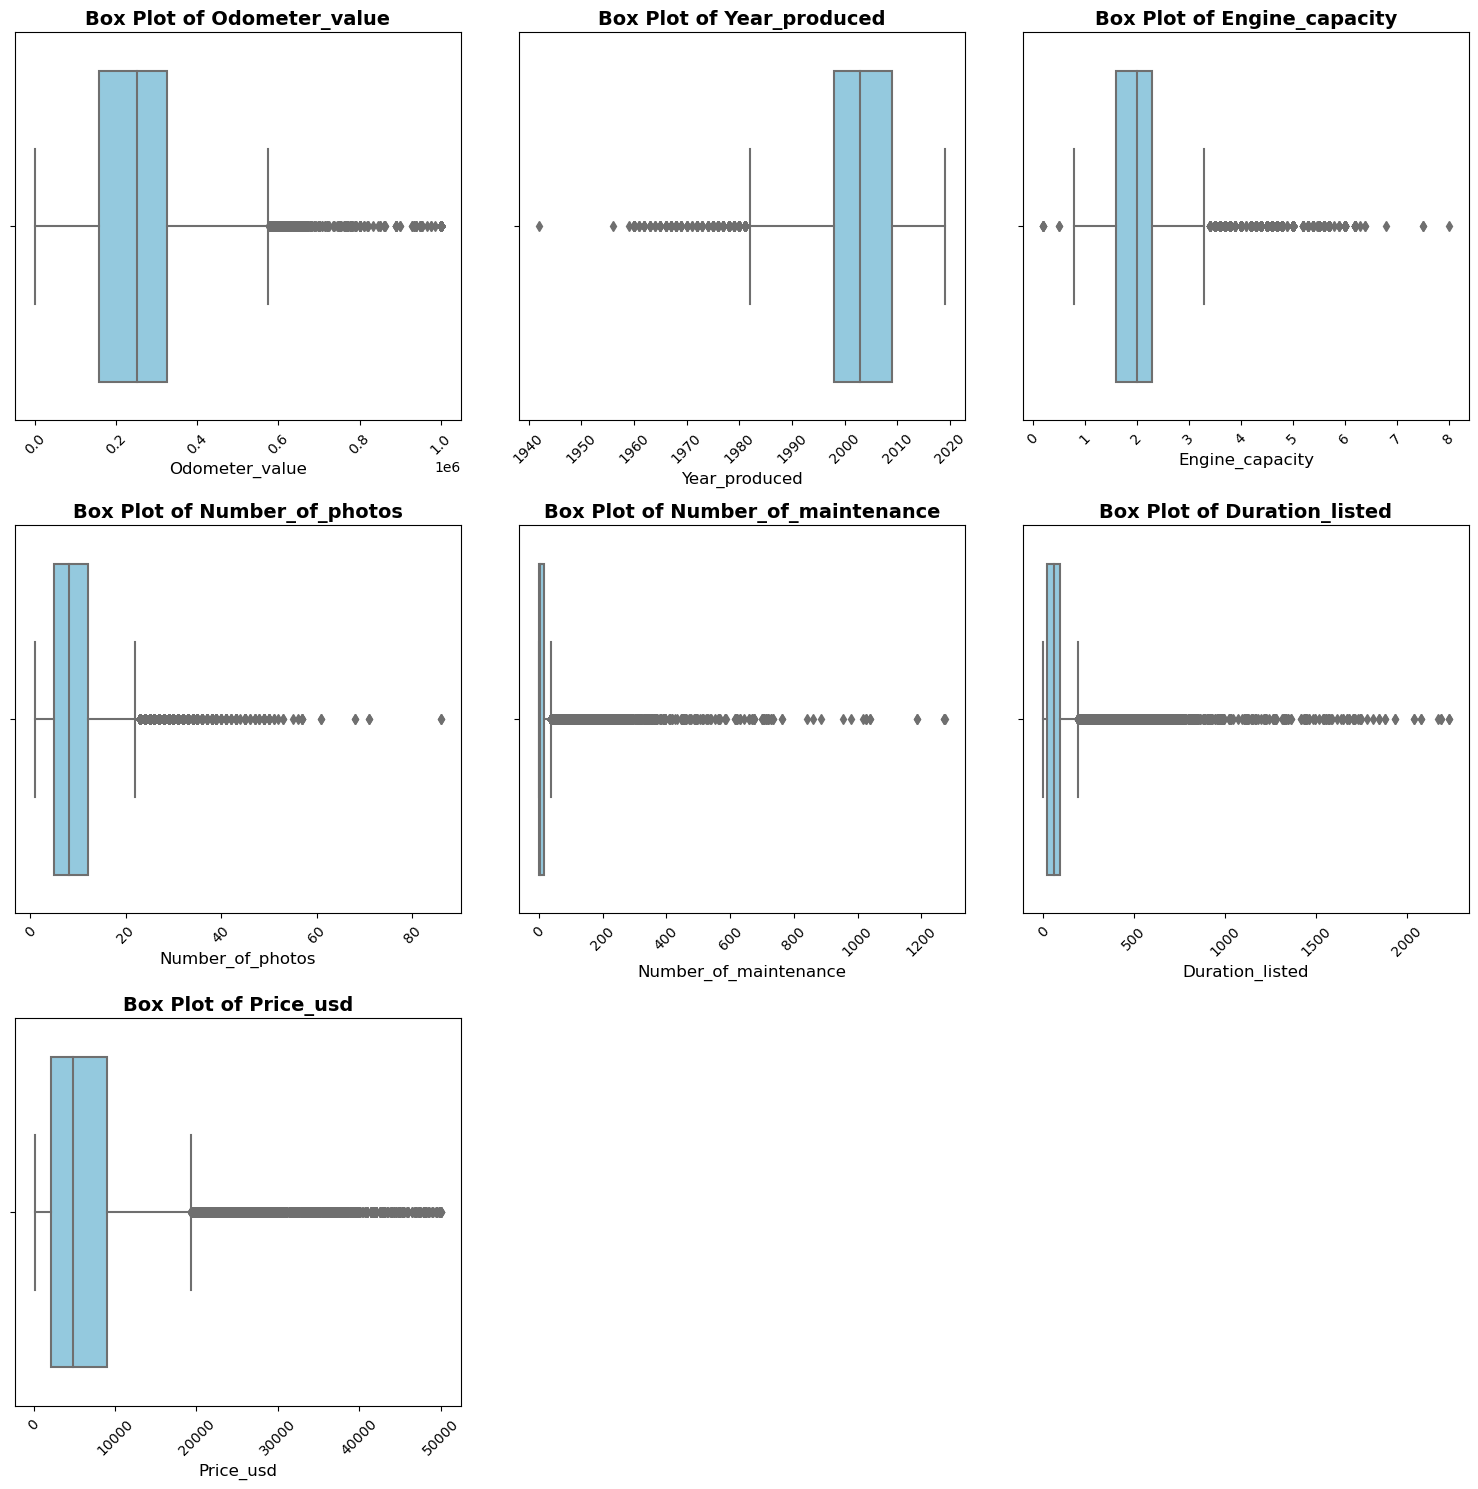

In [30]:
# Number of rows and columns for the subplot
n_rows_outlier = n_rows_non_binary
n_cols_outlier = n_cols_non_binary

# Create subplots
fig, axes = plt.subplots(n_rows_outlier, n_cols_outlier, figsize=(15, n_rows_outlier * 5))
axes = axes.flatten()

# Plot box plots for each numerical non-binary feature
for i, feature in enumerate(numerical_non_binary_features):
    sns.boxplot(x=data_train[feature], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot of {feature.capitalize()}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f'{feature.capitalize()}', fontsize=12)
    axes[i].tick_params(axis='x', labelrotation=45)

# Adjust the spacing between plots
plt.tight_layout()

# Remove any empty subplots
for j in range(i+1, n_rows_outlier * n_cols_outlier):
    fig.delaxes(axes[j])

plt.show()

In [32]:
# Creating a copy of the dataset for transformations
data_transformed = data_train.copy()

# Applying log transformation (adding 1 to avoid log(0))
log_transform_features = ['odometer_value', 'number_of_photos', 'number_of_maintenance', 'duration_listed']
for feature in log_transform_features:
    data_transformed[feature] = np.log1p(data_transformed[feature])

# Applying square root transformation
sqrt_transform_features = ['age_of_car']
for feature in sqrt_transform_features:
    data_transformed[feature] = np.sqrt(data_transformed[feature])

# Applying Box-Cox or Yeo-Johnson transformation
boxcox_transform_features = ['engine_capacity']
pt = PowerTransformer(method='yeo-johnson', standardize=False)  # Using Yeo-Johnson for handling zero values
data_transformed[boxcox_transform_features] = pt.fit_transform(data_transformed[boxcox_transform_features])

KeyError: 'age_of_car'

NameError: name 'boxcox_transform_features' is not defined

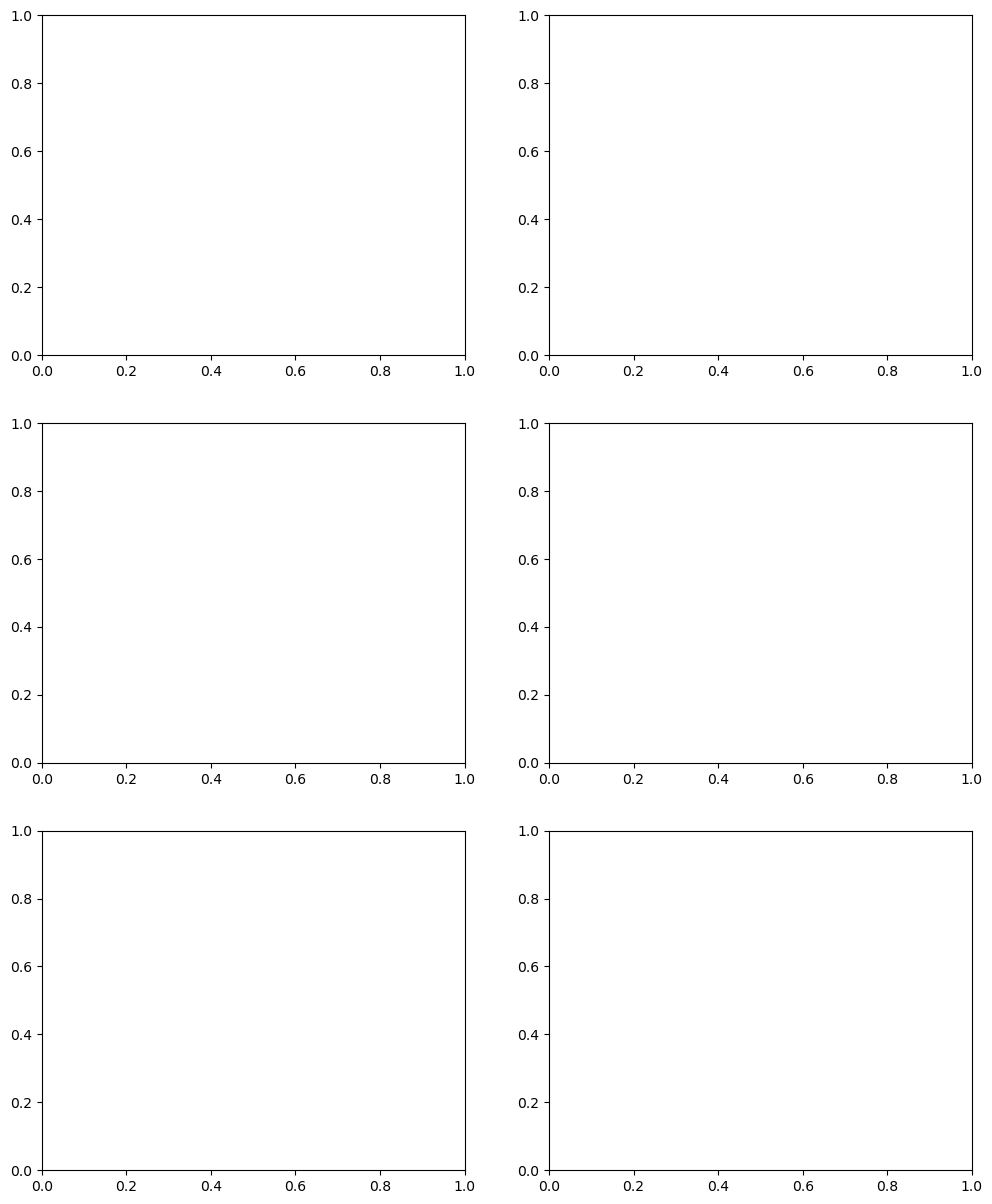

In [34]:
# Visualizing the transformed features
n_rows_transformed = 3
n_cols_transformed = 2
fig, axes = plt.subplots(n_rows_transformed, n_cols_transformed, figsize=(12, 15))
axes = axes.flatten()

# Plot distribution of each transformed feature
for i, feature in enumerate(log_transform_features + sqrt_transform_features + boxcox_transform_features):
    sns.histplot(data_transformed[feature], kde=True, ax=axes[i], color='skyblue', bins=30)
    axes[i].set_title(f'Distribution of {feature.capitalize()} (Transformed)', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f'{feature.capitalize()}', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].tick_params(axis='x', labelrotation=45)

# Adjust the spacing between plots
plt.tight_layout()
plt.show()

In [36]:
data_transformed.head()

,manufacturer_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_type,engine_capacity,body_type,has_warranty,ownership,type_of_drive,is_exchangeable,number_of_photos,number_of_maintenance,duration_listed,price_usd
0,Volkswagen,automatic,black,11.775297,2016,diesel,diesel,1.6,universal,False,owned,front,True,2.890372,3.663562,4.219508,13150.0
1,Renault,manual,brown,11.911708,2012,gasoline,gasoline,1.6,sedan,False,owned,front,False,2.302585,1.386294,4.615121,7500.0
2,Kia,automatic,brown,11.608245,2014,gasoline,gasoline,1.6,hatchback,False,owned,front,False,1.791759,2.397895,4.521789,12200.0
3,Opel,automatic,other,12.449415,2007,gasoline,gasoline,1.8,hatchback,False,owned,front,False,2.397895,1.609438,4.521789,4950.0
4,Mazda,manual,blue,13.384729,1999,gasoline,gasoline,2.0,sedan,False,owned,front,True,1.791759,2.079442,4.143135,3000.0


In [38]:
# Creating a copy of the test dataset for transformations
data_transformed_test = data_test.copy()

# Applying log transformation (adding 1 to avoid log(0))
for feature in log_transform_features:
    if feature in data_transformed_test.columns:
        data_transformed_test[feature] = np.log1p(data_transformed_test[feature])

# Applying square root transformation
for feature in sqrt_transform_features:
    if feature in data_transformed_test.columns:
        data_transformed_test[feature] = np.sqrt(data_transformed_test[feature])

# Applying Box-Cox or Yeo-Johnson transformation
if boxcox_transform_features[0] in data_transformed_test.columns:
    data_transformed_test[boxcox_transform_features] = pt.transform(data_transformed_test[boxcox_transform_features])

data_transformed_test.head()

NameError: name 'boxcox_transform_features' is not defined

In [42]:
 high_priced_outliers.head()

NameError: name 'high_priced_outliers' is not defined

In [44]:
high_priced_outliers.describe()

NameError: name 'high_priced_outliers' is not defined

In [46]:
# 1. Remove the high-priced outliers from the dataset
df_no_outliers = data_transformed[data_transformed['price_usd'] <= upper_bound]

# 2. Apply log transformation to the 'price_usd' column
df_no_outliers['price_usd'] = np.log(df_no_outliers['price_usd'])

# Display the first few rows of the new dataset
df_no_outliers.head()

NameError: name 'upper_bound' is not defined

In [47]:
# Excluding nominal categorical features for correlation analysis
features_to_exclude = ['manufacturer_name', 'model_name', 'color', 'body_type']
features_present = [feature for feature in features_to_exclude if feature in data_transformed.columns]
numerical_and_ordinal_features = data_transformed.drop(columns=features_present)

# Calculating Spearman rank correlation coefficients for all features with respect to price_usd
correlation_spearman = numerical_and_ordinal_features.corr(method='spearman')['price_usd'].sort_values(ascending=False)

# Dropping the correlation of price_usd with itself
correlation_spearman = correlation_spearman.drop(labels=['price_usd'])

ValueError: could not convert string to float: 'automatic'

In [49]:
# Creating a bar plot for the correlation coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_spearman.values, y=correlation_spearman.index, palette='coolwarm')
plt.title('Spearman Rank Correlation with Price (USD)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x')
plt.show()

NameError: name 'correlation_spearman' is not defined

<Figure size 1000x800 with 0 Axes>

In [50]:
# Function to perform ANOVA and return the results
def perform_anova(data, target, categorical_feature):
    # Grouping the data based on categories and creating a list of arrays
    grouped_data = [group[target].values for name, group in data.groupby(categorical_feature)]
    
    # Performing ANOVA
    f_statistic, p_value = f_oneway(*grouped_data)
    return f_statistic, p_value

# Performing ANOVA for each categorical feature
anova_results = {}
for feature in categorical_features:
    if feature in data_train.columns:
        f_statistic, p_value = perform_anova(data_train, 'price_usd', feature)
        anova_results[feature] = {'F-statistic': f_statistic, 'P-value': p_value}

anova_results

{'manufacturer_name': {'F-statistic': 207.90236507576859, 'P-value': 0.0},
 'transmission': {'F-statistic': 14567.54907023448, 'P-value': 0.0},
 'color': {'F-statistic': 555.9458809035775, 'P-value': 0.0},
 'engine_fuel': {'F-statistic': 148.7853625992779,
  'P-value': 2.3702008063280152e-157},
 'engine_type': {'F-statistic': 192.90605340805425,
  'P-value': 3.500430376533125e-84},
 'body_type': {'F-statistic': 1243.7316394119932, 'P-value': 0.0},
 'ownership': {'F-statistic': 2637.9232085676654, 'P-value': 0.0},
 'type_of_drive': {'F-statistic': 5908.154791676644, 'P-value': 0.0}}

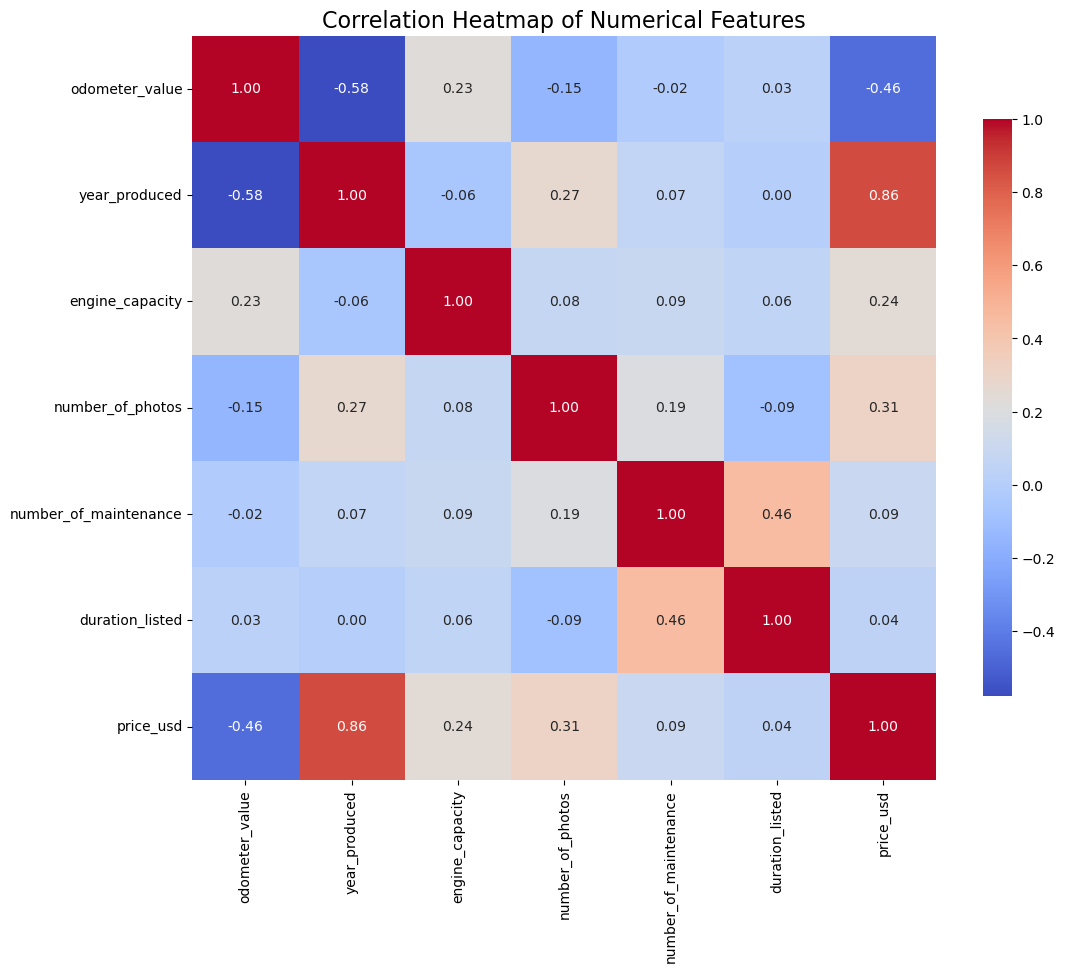

In [52]:
# Calculating the correlation matrix for numerical features
numerical_features = data_transformed.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_features.corr(method='spearman')

# Creating a heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .75})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

In [54]:
list(data_train.columns)

['manufacturer_name',
 'transmission',
 'color',
 'odometer_value',
 'year_produced',
 'engine_fuel',
 'engine_type',
 'engine_capacity',
 'body_type',
 'has_warranty',
 'ownership',
 'type_of_drive',
 'is_exchangeable',
 'number_of_photos',
 'number_of_maintenance',
 'duration_listed',
 'price_usd']

In [56]:
features_to_include = [
    'manufacturer_name',
    'transmission_manual',
    'color',
    'odometer_value',
    'age_of_car',
    'engine_capacity',
    'body_type',
    'has_warranty',
    'ownership_new',
    'front_drive',
    'number_of_photos',
    'number_of_maintenance',
    'duration_listed',
    'price_usd'
]

In [58]:
df_no_outliers=df_no_outliers.dropna()

NameError: name 'df_no_outliers' is not defined

In [59]:
df_no_outliers_test.isna().sum()

NameError: name 'df_no_outliers_test' is not defined

In [61]:
# Identifying Outliers using IQR method for 'price_usd'
Q1 = data_transformed_test['price_usd'].quantile(0.25)
Q3 = data_transformed_test['price_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset for high-priced outliers
high_priced_outliers = data_transformed_test[data_transformed_test['price_usd'] > upper_bound]

# 1. Remove the high-priced outliers from the dataset
df_no_outliers_test = data_transformed_test[data_transformed_test['price_usd'] <= upper_bound]

# 2. Apply log transformation to the 'price_usd' column
df_no_outliers['price_usd'] = np.log(df_no_outliers_test['price_usd'])
df_no_outliers_test=df_no_outliers_test.dropna()
df_no_outliers[features_to_include].to_csv('data_test_2.csv')

NameError: name 'df_no_outliers' is not defined

In [62]:
data_transformed[features_to_include].to_csv('data_transformed_train.csv')
data_transformed_test[features_to_include].to_csv('data_transformed_test.csv')

KeyError: "['transmission_manual', 'age_of_car', 'ownership_new', 'front_drive'] not in index"